In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
import os

In [2]:
FIG_PREFIX = 'traffic'

In [3]:
root_dir = '../result/traffic_result_new2'
root_best_dir = '../result/traffic_best_result'
root_free_dir = '../result/traffic_free_result2'
root_lpms_dir = '../result/traffic_lpms_result'
root_missing_dir = '../result/missing_result/missing_traffic_result'
id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']

In [82]:
def build_stats_filename(row, previous_version, reduced):
    name = row['name']
    if 'parallel' in name:
    # if '-' in name:
        name = name.split('-')[0]
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity'] if row['selectivity'] > 0 else -1), 'stats.csv']
    if not previous_version:
        if reduced is not None:
            fields.insert(-1, str(reduced))
        elif 'BEST' in name:
            fields.insert(-1, '-1')
    space_file = f"time_report_"
    if 'LPMS' in name:
        space_file += f"lpms_t{row['num_threads']}"
        space_file += '_determ' if 'DETER' in name else '_random'
        # max_num = -1
    else:
        space_file += f"{name.lower()}_t{int(row['num_threads'])}"
        if reduced is not None:
            space_file += f"_red{reduced/1000:g}"
        space_file += f"_c{row['selectivity']}"
        if 'FREE' in name:
            space_file += f"_n{int(row['gram_size'])}"
    if 'key_upper_bound' in row:
            space_file += f"_{int(row['key_upper_bound'])}"
            fields.insert(-1, str(int(row['key_upper_bound'])))
    space_file += '.txt'
    return '_'.join(fields), space_file   

In [80]:
def get_compute_space(space_f, root_dir=root_dir):
    fullname = os.path.join(root_dir, space_f)
    try:
        with open(fullname, 'r') as file:
            for line in file:
                if 'Maximum resident set size (kbytes)' in line:
                    return int(line.strip().split(': ')[-1].strip())
    except:
        print(f'Error reading file {fullname}')
        pass
    return -1

In [6]:
def get_stats_df(row, previous_version=False, reduced=None, root_dir=root_dir):
    fname, space_f = build_stats_filename(row, previous_version, reduced)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t'), get_compute_space(space_f, root_dir)

In [7]:
def add_num_after_filter(df, previous_version=False, reduced_list=None, root_dir=root_dir):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': [],
        'compute_size': []
    }
    idx = 0
    reduced = None
    if reduced_list is not None:
        assert(reduced_list is None or len(reduced_list) == df.shape[0])
    for _, row in df.iterrows():
        if reduced_list is not None:
            reduced = reduced_list[idx]
            idx += 1
        detail_df, compute_size = get_stats_df(row, previous_version, reduced=reduced, root_dir=root_dir)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        new_cols['compute_size'].append(compute_size)
    return df.assign(**new_cols)

In [8]:
def build_result_df(root_dir, previous_version=False, reduced=None):
    summary_path = os.path.join(root_dir, 'summary.csv')
    summary_df = pd.read_csv(summary_path)
    summary_df.ffill(inplace=True)
    summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
    summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
    summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']
    # code for getting end-to-end trimmed mean
    summary_df = add_num_after_filter(summary_df, previous_version=previous_version, reduced_list=reduced, root_dir=root_dir)
    res = summary_df.sort_values('overall_time')
    gb = res.groupby(by=id_cols)
    if gb.count()['selection_time'].min() > 2:
        res = res.drop(gb.tail(1).index)
        res = res.drop(gb.head(1).index)
    res_df = res.groupby(by=id_cols, as_index=False).min(numeric_only=True).apply(lambda x: x)
    return res_df

In [72]:
res_df1 = build_result_df(root_dir, previous_version=True)
res_df1 = res_df1.loc[~((res_df1['gram_size'] == 2) & (res_df1['selectivity'] == 0.7))] 
res_df1 = res_df1.loc[~((res_df1['gram_size'] == 4) & (res_df1['selectivity'] == 0.3))] 

res_df1.describe()

,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,4.340000e+02,434.000000,434.000000,434.000000,434.000000,4.340000e+02,4.340000e+02,434.0,434.0
mean,4.675115,4.834101,0.153917,11631.087558,296.972596,31.127888,328.100586,7.040298e+08,0.000856,2.420204,2.421133,330.521719,4.298988e+06,1.074747e+06,368166.0,-1.0
std,3.320171,3.417809,0.177600,14420.059483,1920.513757,32.112451,1917.289653,3.802638e+08,0.001081,0.922565,0.922878,1917.200091,2.839921e+06,7.099803e+05,0.0,0.0
min,1.000000,-1.000000,0.010000,2.000000,17.442700,0.000080,21.995500,2.240000e+02,0.000076,1.079191,1.079542,23.730300,4.539400e+05,1.134850e+05,368166.0,-1.0
25%,1.000000,2.000000,0.030000,1987.000000,30.925425,8.628720,45.509150,4.484203e+08,0.000164,1.907579,1.908038,48.325594,2.993200e+06,7.483000e+05,368166.0,-1.0
50%,4.000000,6.000000,0.100000,6639.000000,52.433600,20.151950,77.269900,8.598041e+08,0.000517,2.004744,2.005583,79.866901,2.993334e+06,7.483335e+05,368166.0,-1.0
75%,8.000000,8.000000,0.200000,14816.000000,89.887050,44.938650,149.671250,9.931850e+08,0.001072,2.941343,2.942120,151.686714,5.734148e+06,1.433537e+06,368166.0,-1.0
max,10.000000,10.000000,0.700000,66147.000000,36179.800000,171.487000,36179.900000,1.176186e+09,0.010667,4.936243,4.936406,36181.231957,1.138137e+07,2.845343e+06,368166.0,-1.0


In [10]:
res_df1

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
0,BEST,1.0,-1.0,0.01,2.0,41.4722,0.000382,41.4726,224.0,0.000091,3.791538,3.791629,45.264229,8540928,2135232.00,368166,-1
1,BEST,1.0,-1.0,0.02,3.0,89.8524,0.002647,89.8550,400.0,0.000082,2.941589,2.941671,92.796671,5726490,1431622.50,368166,-1
2,BEST,1.0,-1.0,0.03,5.0,340.0150,0.004944,340.0200,1032.0,0.000090,2.957958,2.958052,342.978052,5734148,1433537.00,368166,-1
3,BEST,1.0,-1.0,0.05,7.0,1275.5500,0.007695,1275.5600,1032.0,0.000086,1.977473,1.977561,1277.537561,2993200,748300.00,368166,-1
4,BEST,1.0,-1.0,0.07,8.0,1749.7800,0.008987,1749.7900,1592.0,0.000088,1.989573,1.989661,1751.779661,2993200,748300.00,368166,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,FREE-presuf,1.0,10.0,0.12,6012.0,116.4300,84.928400,201.3580,724472232.0,0.000495,1.931654,1.932149,203.290149,2993334,748333.50,368166,-1
444,FREE-presuf,1.0,10.0,0.15,5393.0,112.3470,81.650800,193.9980,747973728.0,0.000474,1.892689,1.893166,195.891166,2993334,748333.50,368166,-1
445,FREE-presuf,1.0,10.0,0.20,4549.0,104.1330,75.540000,179.6730,799369534.0,0.000407,2.096918,2.097325,181.770325,3437533,859383.25,368166,-1
446,FREE-presuf,1.0,10.0,0.30,2760.0,87.4628,62.395300,149.8580,889122886.0,0.000330,1.359290,1.359640,151.217640,895739,223934.75,368166,-1


In [11]:
res_lpms_df = build_result_df(root_lpms_dir)
res_lpms_df.describe()

,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,4.0,4.0,4.0,4.000000,4.000000,4.0,4.000000,4.0,4.000000,4.000000e+00,4.000000,4.000000,4.000000,4.000000,4.000000e+00,4.000000e+00,4.0,4.000000e+00
mean,16.0,-1.0,-1.0,6.750000,8.750000,4.0,227.540825,-1.0,227.540825,4.348325e+07,0.000393,2.345912,2.346305,229.892102,3.606428e+06,9.016071e+05,368166.0,3.047303e+06
std,0.0,0.0,0.0,5.377422,4.787136,0.0,211.397051,0.0,211.397051,2.919132e+07,0.000505,1.672301,1.672191,212.865832,5.209876e+06,1.302469e+06,0.0,1.105568e+06
min,16.0,-1.0,-1.0,0.000000,5.000000,4.0,34.914300,-1.0,34.914300,8.280000e+03,0.000132,1.352561,1.352715,36.737224,6.431180e+05,1.607795e+05,368166.0,2.139184e+06
25%,16.0,-1.0,-1.0,3.750000,5.000000,4.0,99.232575,-1.0,99.232575,3.981179e+07,0.000134,1.370096,1.370234,100.720361,6.431292e+05,1.607823e+05,368166.0,2.433070e+06
50%,16.0,-1.0,-1.0,7.500000,7.500000,4.0,177.661000,-1.0,177.661000,5.653984e+07,0.000144,1.598857,1.599499,179.025394,1.200612e+06,3.001530e+05,368166.0,2.703510e+06
75%,16.0,-1.0,-1.0,10.500000,11.250000,4.0,305.969250,-1.0,305.969250,6.021129e+07,0.000403,2.574673,2.575570,308.197135,4.163911e+06,1.040978e+06,368166.0,3.317743e+06
max,16.0,-1.0,-1.0,12.000000,15.000000,4.0,519.927000,-1.0,519.927000,6.084502e+07,0.001151,4.833372,4.833507,524.780396,1.138137e+07,2.845343e+06,368166.0,4.643008e+06


In [12]:
res_best_df = build_result_df(root_best_dir)
res_best_df.describe()

,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,12.0,12.0,12.000000,12.000000,12.000000,12.0,12.000000,12.000000,12.000000,1.200000e+01,12.000000,12.000000,12.000000,12.000000,1.200000e+01,1.200000e+01,12.0,1.200000e+01
mean,16.0,-1.0,0.318333,6.916667,7.916667,4.0,51.013725,0.005610,51.019392,2.120259e+07,0.000133,1.881944,1.882078,52.910515,2.315621e+06,5.789053e+05,368166.0,1.560411e+06
std,0.0,0.0,0.279507,2.810963,3.342790,0.0,6.080430,0.006273,6.086332,2.660732e+07,0.000006,0.460803,0.460799,5.747847,1.525969e+06,3.814922e+05,0.0,4.467614e+05
min,16.0,-1.0,0.020000,3.000000,5.000000,4.0,45.683500,0.000341,45.683900,6.408960e+05,0.000126,1.445178,1.445317,48.727449,7.216870e+05,1.804218e+05,368166.0,1.187236e+06
25%,16.0,-1.0,0.087500,5.000000,5.000000,4.0,46.795375,0.001599,46.796775,3.702384e+06,0.000128,1.454816,1.454951,48.838786,8.747838e+05,2.186959e+05,368166.0,1.220563e+06
50%,16.0,-1.0,0.200000,6.000000,7.500000,4.0,46.997550,0.002838,46.999550,6.322992e+06,0.000131,2.028460,2.028600,49.056652,2.993200e+06,7.483000e+05,368166.0,1.231354e+06
75%,16.0,-1.0,0.550000,8.250000,10.000000,4.0,54.647275,0.007995,54.656025,3.316921e+07,0.000136,2.046755,2.046882,56.130878,2.993740e+06,7.484349e+05,368166.0,1.886022e+06
max,16.0,-1.0,0.700000,13.000000,15.000000,4.0,62.820600,0.021698,62.842300,8.479626e+07,0.000145,3.019874,3.020001,64.293306,5.726490e+06,1.431622e+06,368166.0,2.245864e+06


In [13]:
res_free_df = build_result_df(root_free_dir)
res_free_df.describe()

,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,312.0,312.000000,312.000000,312.000000,312.000000,312.0,312.000000,312.000000,312.000000,3.120000e+02,312.000000,312.000000,312.000000,312.000000,3.120000e+02,3.120000e+02,312.0,3.120000e+02
mean,16.0,6.102564,0.225962,2002.717949,7.307692,0.0,34.803571,4.623193,39.426764,2.055011e+08,0.000254,4.316403,4.316657,43.743421,9.370937e+06,2.342734e+06,368166.0,1.392175e+06
std,0.0,2.794527,0.224373,5273.566271,6.006016,0.0,16.850227,3.067712,19.615661,3.712040e+08,0.000267,1.168995,1.168877,18.825554,3.665652e+06,9.164130e+05,0.0,7.863367e+05
min,16.0,2.000000,0.020000,5.000000,-1.000000,0.0,26.130100,0.942652,27.432900,1.537800e+04,0.000139,1.604393,1.604593,31.851365,7.510530e+05,1.877632e+05,368166.0,9.680760e+05
25%,16.0,4.000000,0.050000,10.000000,-1.000000,0.0,27.515350,2.600665,30.329150,2.246000e+04,0.000164,4.736376,4.736541,35.150869,1.067968e+07,2.669920e+06,368166.0,9.689220e+05
50%,16.0,6.000000,0.120000,15.000000,10.000000,0.0,27.929050,3.828500,31.608150,2.310200e+04,0.000184,4.932420,4.932604,36.529767,1.138137e+07,2.845343e+06,368166.0,9.695460e+05
75%,16.0,8.000000,0.200000,759.000000,15.000000,0.0,28.481725,5.440325,33.696675,1.731031e+08,0.000204,4.953396,4.953574,38.487069,1.138137e+07,2.845343e+06,368166.0,1.068100e+06
max,16.0,10.000000,0.700000,39801.000000,15.000000,0.0,109.412000,18.341300,127.754000,1.148469e+09,0.002459,5.424889,5.425059,130.936597,1.138137e+07,2.845343e+06,368166.0,3.634884e+06


In [83]:
res_missing_df = build_result_df(root_missing_dir)
res_missing_df.describe()

Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_r

,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,3.000000,3.000000,3.000000,3.000000,3.0,3.0,3.000000,3.000000,3.000000,3.000000e+00,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000e+00
mean,14.000000,3.333333,0.433333,2989.666667,-1.0,0.0,36.873200,5.657503,42.530700,1.048642e+09,0.000296,1.391678,1.391984,43.922684,569324.666667,142331.166667,368166.0,2.153725e+06
std,3.464102,1.154701,0.230940,1864.264019,0.0,0.0,7.814142,2.263393,9.997468,3.866981e+07,0.000122,0.166786,0.166657,9.834632,199852.105081,49963.026270,0.0,1.865451e+06
min,10.000000,2.000000,0.300000,837.000000,-1.0,0.0,27.957200,3.311890,31.269100,1.003990e+09,0.000155,1.293896,1.294281,32.853515,453940.000000,113485.000000,368166.0,-1.000000e+00
25%,13.000000,3.000000,0.300000,2451.500000,-1.0,0.0,34.044300,4.571970,38.616250,1.037479e+09,0.000260,1.295388,1.295768,40.057085,453940.000000,113485.000000,368166.0,1.599446e+06
50%,16.000000,4.000000,0.300000,4066.000000,-1.0,0.0,40.131400,5.832050,45.963400,1.070968e+09,0.000366,1.296880,1.297255,47.260655,453940.000000,113485.000000,368166.0,3.198892e+06
75%,16.000000,4.000000,0.500000,4066.000000,-1.0,0.0,41.331200,6.830310,48.161500,1.070968e+09,0.000367,1.440569,1.440835,49.457268,627017.000000,156754.250000,368166.0,3.230588e+06
max,16.000000,4.000000,0.700000,4066.000000,-1.0,0.0,42.531000,7.828570,50.359600,1.070968e+09,0.000368,1.584258,1.584415,51.653881,800094.000000,200023.500000,368166.0,3.262284e+06


In [63]:
res_missing_df.columns

Index(['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys',
       'key_upper_bound', 'num_queries', 'selection_time', 'build_time',
       'overall_index_time', 'index_size', 'compile_time', 'match_time',
       'overall_match_time', 'overall_time', 'num_after_filter',
       'per_query_num_after_filter', 'match_count', 'compute_size'],
      dtype='object')

In [64]:
res_df1.columns

Index(['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys',
       'selection_time', 'build_time', 'overall_index_time', 'index_size',
       'compile_time', 'match_time', 'overall_match_time', 'overall_time',
       'num_after_filter', 'per_query_num_after_filter', 'match_count',
       'compute_size'],
      dtype='object')

In [84]:
res_df = pd.concat([res_df1, res_best_df, res_free_df, res_lpms_df, res_missing_df], ignore_index=True)

In [85]:
# explore the distribution of number of keys and number
res_df['prop_error'] = (res_df['num_after_filter'] - res_df['match_count']) / res_df['num_after_filter']
res_df['precision'] = ( res_df['match_count']) / res_df['num_after_filter']
res_df['method'] = [name.split('-')[0] for name in res_df['name']]
# res_df = res_df[(res_df['num_threads']==16) | (res_df['num_threads']==10)]
res_df = res_df[res_df['num_threads']==16]
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'precision', 'num_keys']).gram_size.idxmin()].sort_values(by='num_keys')
new_groups = new_res_df.groupby(['method', 'gram_size'])

In [86]:
res_df[(res_df.method == 'FREE') & (res_df.gram_size==4) & (res_df.selectivity==0.3)]

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,method
764,FREE-parallel,16.0,4.0,0.3,4066.0,40.1314,5.83205,45.9634,1.070968e+09,0.000368,...,47.260655,453940,113485.0,368166,3198892,-1.0,0.0,0.188954,0.811046,FREE


In [87]:
res_df[res_df.match_time == res_df.match_time.min()]

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,method
764,FREE-parallel,16.0,4.0,0.3,4066.0,40.1314,5.83205,45.9634,1.070968e+09,0.000368,...,47.260655,453940,113485.0,368166,3198892,-1.0,0.0,0.188954,0.811046,FREE


In [88]:
new_res_df[['name','gram_size','selectivity','num_keys','precision']]

,name,gram_size,selectivity,num_keys,precision
761,LPMS-RANDOM,-1.0,-1.00,0.0,0.032348
434,BEST-parallel,-1.0,0.02,3.0,0.064292
435,BEST-parallel,-1.0,0.05,5.0,0.122938
439,BEST-parallel,-1.0,0.20,5.0,0.122975
446,FREE-parallel,2.0,0.02,5.0,0.032348
...,...,...,...,...,...
577,FREE-parallel,10.0,0.05,19138.0,0.123001
477,FREE-parallel,4.0,0.02,25651.0,0.064292
509,FREE-parallel,6.0,0.02,33813.0,0.064322
541,FREE-parallel,8.0,0.02,37650.0,0.064322


In [95]:
name_map = {
    'BEST' : '\\best ',
    'FREE' : '\\free ',
    'FAST' : '\\lpms ',
    'LPMS' : '\\lpms '
}

def check_min_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].min():
        curr_str += '& \cellcolor{green!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str

def check_max_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].max():
        curr_str += '& \cellcolor{yellow!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str
summary_df = None
# lims = [30, 50, 100, 500, 1000, 5000, 10000]
lims = [30, 1000, 5000]
for up_lim in lims:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    # curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    curr_group = curr_df.sort_values(by=['precision', 'index_size'], ascending=[False, True]).groupby(['method']).first()
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    # print(curr_group)
    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    curr_group = curr_group.sort_values(by='name')
    count = 0
    curr_row_count = curr_group.shape[0]
    curr_group['max_key'] = [up_lim]*curr_row_count    
    for _, row in curr_group.iterrows():
        curr_str = ''
        count += 1;
        if count == 1:
            curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+str(up_lim)+'}}'
        curr_str += f'& {name_map[row["name"][:4]]} '

        curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.3f}', curr_group)
        curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.3f}', curr_group)
        curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.2f}', curr_group)
        curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3f}', curr_group)
        print(curr_str, end='')
        if count < curr_row_count:
            print("\\\\ ")
        else:
            print("\\\\ \midrule")
            
    app = []
    for m in ['BEST', 'FREE', 'LPMS']:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)

    if summary_df is None:
        summary_df = curr_group
    else:
        summary_df = pd.concat([summary_df, curr_group], ignore_index=True)
summary_df['name'] = [ nm.split('-')[0] for nm in summary_df['name'].to_list()]

\multirow{3}{*}{\bf{30}}& \best  & 1.451 & 63 & 2.204 & 84.80 & 0.510 \\ 
& \free  & 4.940 & \cellcolor{green!50}{29} & \cellcolor{green!50}{0.969} & \cellcolor{green!50}{0.02} & 0.032 \\ 
& \lpms  & \cellcolor{green!50}{1.353} & 235 & 2.876 & 60.85 & \cellcolor{yellow!50}{0.572} \\ \midrule
\multirow{3}{*}{\bf{1000}}& \best  & 1.451 & 63 & \cellcolor{green!50}{2.204} & 84.80 & 0.510 \\ 
& \free  & 1.708 & \cellcolor{green!50}{31} & 3.235 & 1003.99 & 0.460 \\ 
& \lpms  & \cellcolor{green!50}{1.353} & 235 & 2.876 & \cellcolor{green!50}{60.85} & \cellcolor{yellow!50}{0.572} \\ \midrule
\multirow{3}{*}{\bf{5000}}& \best  & 1.451 & 63 & \cellcolor{green!50}{2.204} & 84.80 & 0.510 \\ 
& \free  & \cellcolor{green!50}{1.297} & \cellcolor{green!50}{46} & 3.199 & 1070.97 & \cellcolor{yellow!50}{0.811} \\ 
& \lpms  & 1.353 & 235 & 2.876 & \cellcolor{green!50}{60.85} & 0.572 \\ \midrule


In [97]:
summary_df

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,max_key
0,BEST,16.0,-1.0,0.70,13.0,62.8206,0.021698,62.8423,8.479626e+07,0.000145,...,64.293306,721687,180421.75,368166,2204460,30,4.0,0.489854,0.510146,30
1,FREE,16.0,2.0,0.02,5.0,28.3297,0.942652,29.2724,1.537800e+04,0.000173,...,34.212158,11381372,2845343.00,368166,969100,30,0.0,0.967652,0.032348,30
2,LPMS,16.0,-1.0,-1.00,12.0,234.6500,-1.000000,234.6500,6.084502e+07,0.000154,...,236.002715,643118,160779.50,368166,2875988,30,4.0,0.427530,0.572470,30
3,BEST,16.0,-1.0,0.70,13.0,62.8206,0.021698,62.8423,8.479626e+07,0.000145,...,64.293306,721687,180421.75,368166,2204460,1000,4.0,0.489854,0.510146,1000
4,FREE,16.0,2.0,0.70,837.0,27.1897,3.756110,30.9458,1.003990e+09,0.000195,...,32.653300,800094,200023.50,368166,3234844,1000,0.0,0.539847,0.460153,1000
5,LPMS,16.0,-1.0,-1.00,12.0,234.6500,-1.000000,234.6500,6.084502e+07,0.000154,...,236.002715,643118,160779.50,368166,2875988,1000,4.0,0.427530,0.572470,1000
6,BEST,16.0,-1.0,0.70,13.0,62.8206,0.021698,62.8423,8.479626e+07,0.000145,...,64.293306,721687,180421.75,368166,2204460,5000,4.0,0.489854,0.510146,5000
7,FREE,16.0,4.0,0.30,4066.0,40.1314,5.832050,45.9634,1.070968e+09,0.000368,...,47.260655,453940,113485.00,368166,3198892,5000,0.0,0.188954,0.811046,5000
8,LPMS,16.0,-1.0,-1.00,12.0,234.6500,-1.000000,234.6500,6.084502e+07,0.000154,...,236.002715,643118,160779.50,368166,2875988,5000,4.0,0.427530,0.572470,5000


In [23]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [24]:
import matplotlib
print(matplotlib.__version__)


3.5.3


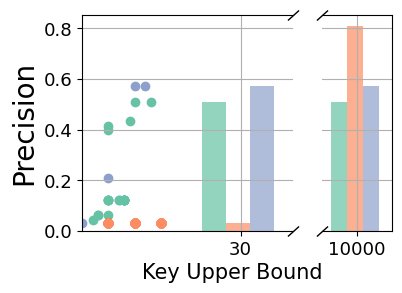

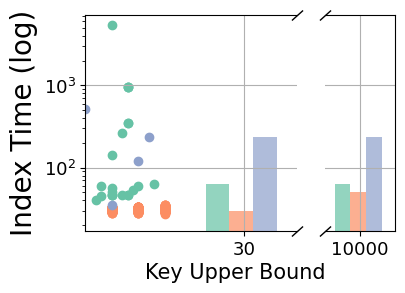

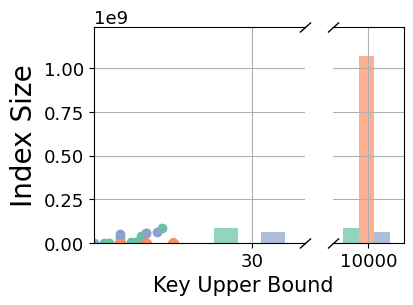

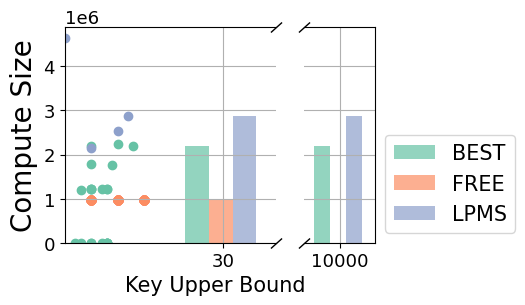

In [25]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for col in ['precision', 'overall_index_time', 'index_size', 'compute_size']:
    # fig, ax = plt.subplots(figsize=(4,2.8))
    
    # fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, width_ratios=(0.75,0.25), figsize=(4,2.8))
    # fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [3, 1]}, figsize=(4,2.8))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [3, 1]}, figsize=(4,2.8))
    fig.subplots_adjust(hspace=0.01)  # adjust space between Axes
    
    x = np.array(lims)-5  # the label locations
    width1 = 0.15*30  # the width of the bars
    width2 = 0.15 *200 # the width of the bars
    multiplier = 0
    for method, color in zip(['BEST', 'FREE', 'LPMS'], colors):
        curr = summary_df.loc[summary_df["name"] == method]#.sort_values('name')
        
        X = curr['key_upper_bound']
        
        # fig, ax = plt.subplots(layout='constrained')
        prev = 0
        offset = width1 * multiplier
        Y = curr[col].to_numpy()
        if col == 'compute_size':
            rects = ax1.bar(x + offset, Y, width1, alpha=0.7, color=color)
            rects = ax2.bar(x + offset, Y, width1, alpha=0.7, label=method, color=color)
        else:
            rects = ax1.bar(x + offset, Y, width1, alpha=0.7, color=color)
            rects = ax2.bar(x + offset, Y, width1, alpha=0.7, color=color)

        multiplier += 1

        curr_all_df = res_df[(res_df["method"] == method) & (res_df["num_keys"] <= lims[-1])]
        ax1.scatter(curr_all_df['num_keys'], curr_all_df[col], c=color)
        ax2.scatter(curr_all_df['num_keys'], curr_all_df[col], c=color)
        # print(res_df[(res_df['num_keys'] > 8500) & (res_df["method"] == method)])
        # print(lims[-1])
    ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
    if col == 'overall_index_time':
        ax1.set_yscale('log')
        ax2.set_yscale('log')

        ylb += ' (log)'
        # ax1.ticklabel_format(axis='x', scilimits=[-3,3])
        # ax2.ticklabel_format(axis='x', scilimits=[-3,3])
    # else:
    #     ax1.ticklabel_format(scilimits=[-3,3])
    #     ax2.ticklabel_format(scilimits=[-3,3])

    # zoom-in / limit the view to different portions of the data
      
    ax1.set_xlim(0, 40)  
    ax2.set_xlim(9990, 10010)  
    ax1.set_ylabel(ylb)
    # ax1.set_xscale('log')

    # hide the spines between ax and ax2
    ax1.spines.right.set_visible(False)
    ax2.spines.left.set_visible(False)
    ax2.tick_params(axis='y', which='both', left=False)  

    ax1.set_xticks(ticks=lims[:1])#, labels=[f'{int(v/1000)}k' for v in lims[1:]])
    ax2.set_xticks(ticks=lims[-1:])#, labels=[f'{int(v/1000)}k' for v in lims[1:]])
    d = .9  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([1, 1], [1, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
    if col == 'compute_size':
        plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    ax1.grid()
    ax2.grid()
    fig.text(0.5, -0.04, 'Key Upper Bound', ha='center', va='center')
    plt.savefig(f'figs/{FIG_PREFIX}_{col}.pdf', bbox_inches='tight')
    plt.show()

('BEST', -1.0)
('FREE', 2.0)
('FREE', 4.0)
('FREE', 6.0)
('FREE', 8.0)
('FREE', 10.0)
('LPMS', -1.0)


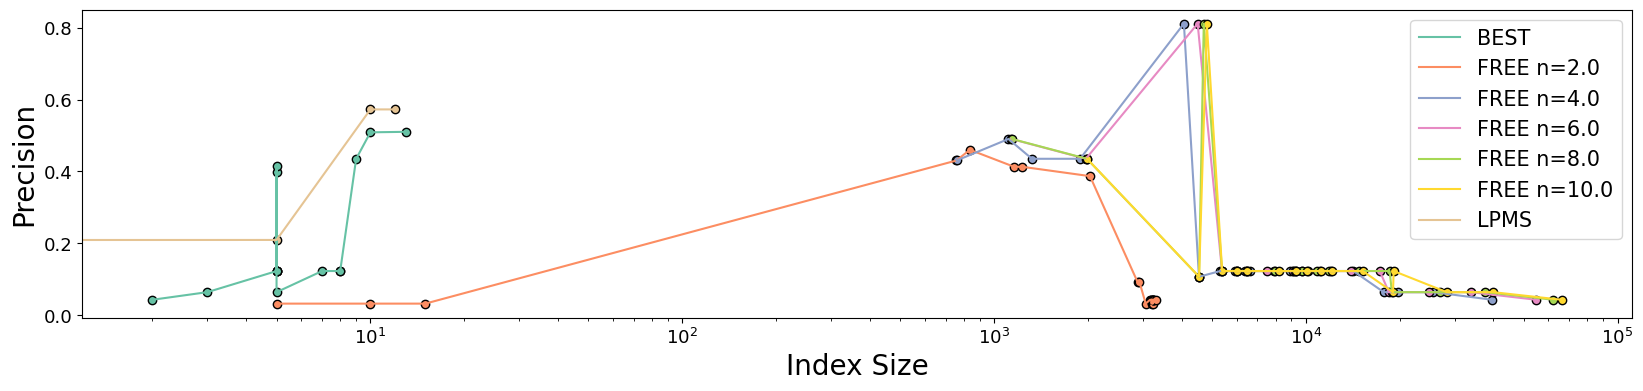

In [26]:
fig, ax = plt.subplots(figsize=(20,4))
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 0

    X = new_group['num_keys']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color, label=curr_lab)
    ax.scatter(X, Y, marker='o', #label=curr_lab, 
               c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               #s=1000*new_group['selectivity'].to_numpy()
              )
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
plt.gca().set_xscale("log")
ax.set_xlabel('Index Size')
ax.set_ylabel('Precision')

# ax.set_xlim([0, 5000])
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_constrSize_prec.pdf', bbox_inches='tight')
plt.show()

('BEST', -1.0)
('FREE', 2.0)
('FREE', 4.0)
('FREE', 6.0)
('FREE', 8.0)
('FREE', 10.0)
('LPMS', -1.0)


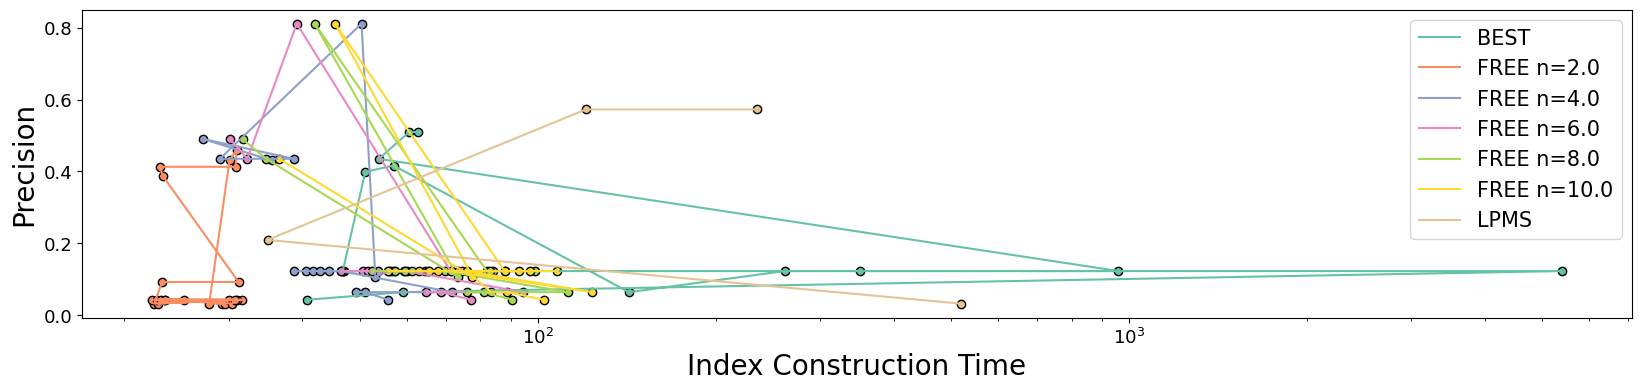

In [27]:
fig, ax = plt.subplots(figsize=(20,4))

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 0

    X = new_group['overall_index_time']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color, label=curr_lab)
    ax.scatter(X, Y, marker='o', #label=curr_lab, 
               c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               #s=1000*new_group['selectivity'].to_numpy()
              )
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
plt.gca().set_xscale("log")
ax.set_xlabel('Index Construction Time')
ax.set_ylabel('Precision')

# ax.set_xlim([0, 5000])
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_constrTime_prec.pdf', bbox_inches='tight')
plt.show()

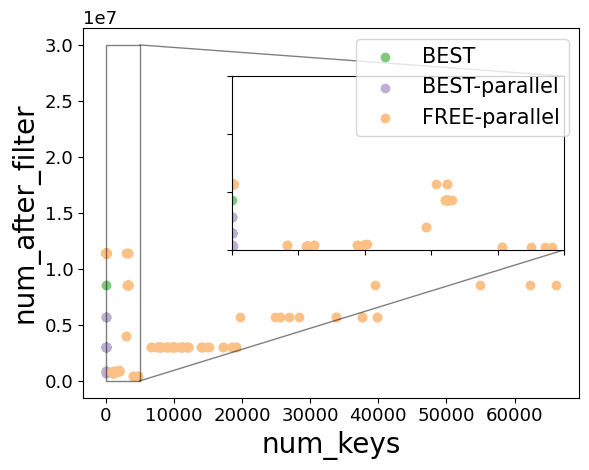

In [28]:
# explore the distribution of number of keys and number

groups = res_df.groupby('name')
colors = ['#7fc97f','#beaed4','#fdc086']
ax = plt.subplot()
for (name, group), color in zip(groups, colors):
    ax.scatter(group['num_keys'], group['num_after_filter'], c=color, label=name)
ax.set_xlabel('num_keys')
ax.set_ylabel('num_after_filter')

# inset Axes....
x1, x2, y1, y2 = 0,5000, 0, 30000000  # subregion of the original image
axins = ax.inset_axes(
    [0.3, 0.4, 0.67, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
for (name, group), color in zip(groups, colors):
    axins.scatter(group['num_keys'], group['num_after_filter'], c=color, label=name)
# axins.scatter(res_df['num_keys'], res_df['num_after_filter'])
plt.legend()
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

In [29]:
# get their configurations
curr_examine = res_df[(res_df['num_keys'] <= x2) & (res_df['num_after_filter'] <= y2)]
trimed = curr_examine.loc[curr_examine.groupby('num_after_filter').gram_size.idxmin()]
trimed = trimed.sort_values(by='num_after_filter')

In [30]:
trimed

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,method
766,FREE-parallel,10.0,4.0,0.30,4066.0,42.5310,7.828570,50.3596,1.070968e+09,0.000366,...,51.653881,453940,113485.00,368166,-1,-1.0,0.0,0.188954,0.811046,FREE
764,LPMS-DETERM,16.0,-1.0,-1.00,12.0,234.6500,-1.000000,234.6500,6.084502e+07,0.000154,...,236.002715,643118,160779.50,368166,2875988,15.0,4.0,0.427530,0.572470,LPMS
763,LPMS-DETERM,16.0,-1.0,-1.00,10.0,120.6720,-1.000000,120.6720,6.000005e+07,0.000132,...,122.048073,643133,160783.25,368166,2531032,10.0,4.0,0.427543,0.572457,LPMS
449,BEST-parallel,16.0,-1.0,0.70,13.0,62.8206,0.021698,62.8423,8.479626e+07,0.000145,...,64.293306,721687,180421.75,368166,2204460,15.0,4.0,0.489854,0.510146,BEST
448,BEST-parallel,16.0,-1.0,0.70,10.0,60.5354,0.012429,60.5479,5.616079e+07,0.000139,...,61.993217,723699,180924.75,368166,2245864,10.0,4.0,0.491272,0.508728,BEST
343,FREE-parallel,10.0,4.0,0.70,1113.0,21.7591,5.415850,27.1749,1.084753e+09,0.000163,...,28.523673,751053,187763.25,368166,-1,NaN,NaN,0.509800,0.490200,FREE
477,FREE-parallel,16.0,2.0,0.70,837.0,27.1897,3.756110,30.9458,1.003990e+09,0.000195,...,32.653300,800094,200023.50,368166,3234844,-1.0,0.0,0.539847,0.460153,FREE
342,FREE-parallel,10.0,4.0,0.50,1889.0,22.8775,6.117840,28.9953,1.087380e+09,0.000221,...,30.440536,846059,211514.75,368166,-1,NaN,NaN,0.564846,0.435154,FREE
446,BEST-parallel,16.0,-1.0,0.50,9.0,53.8472,0.009051,53.8563,3.752166e+07,0.000136,...,55.320046,846295,211573.75,368166,1773968,10.0,4.0,0.564967,0.435033,BEST
633,FREE-presuf,16.0,2.0,0.70,758.0,26.9539,3.160000,30.1139,8.815533e+08,0.000176,...,31.851365,855412,213853.00,368166,2916208,-1.0,0.0,0.569604,0.430396,FREE


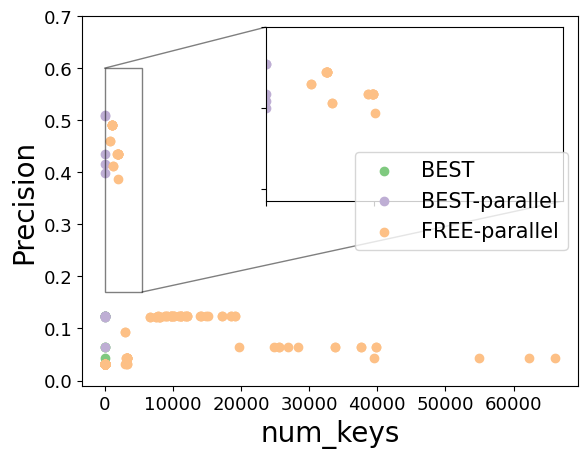

In [31]:
groups = res_df.groupby('name')
colors = ['#7fc97f','#beaed4','#fdc086']
ax = plt.subplot()
ax.set_ylim([-0.01, 0.7])
for (name, group), color in zip(groups, colors):
    ax.scatter(group['num_keys'], group['precision'], c=color, label=name)
ax.set_xlabel('num_keys')
ax.set_ylabel('Precision')

# print( res_df['match_count'])
# print(res_df['num_after_filter'])
# print(res_df['prop_error'])
# print((239136631-913841)/239136631)

# inset Axes....
x1, x2, y1, y2 = 0,5500, 0.17, 0.6  # subregion of the original image
axins = ax.inset_axes(
    [0.37, 0.5, 0.6, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
for (name, group), color in zip(groups, colors):
    axins.scatter(group['num_keys'], group['precision'], c=color, label=name)
# axins.scatter(res_df['num_keys'], res_df['num_after_filter'])
plt.legend(loc='center right')
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

In [32]:
# get their configurations
curr_examine = res_df[(res_df['num_keys'] <= x2) & (res_df['precision']>= y1)]
trimed = curr_examine.loc[curr_examine.groupby('num_after_filter').gram_size.idxmin()]
sorted_df = trimed.sort_values(by='precision')

In [33]:
trimed

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,method
766,FREE-parallel,10.0,4.0,0.3,4066.0,42.5310,7.828570,50.3596,1.070968e+09,0.000366,...,51.653881,453940,113485.00,368166,-1,-1.0,0.0,0.188954,0.811046,FREE
764,LPMS-DETERM,16.0,-1.0,-1.0,12.0,234.6500,-1.000000,234.6500,6.084502e+07,0.000154,...,236.002715,643118,160779.50,368166,2875988,15.0,4.0,0.427530,0.572470,LPMS
763,LPMS-DETERM,16.0,-1.0,-1.0,10.0,120.6720,-1.000000,120.6720,6.000005e+07,0.000132,...,122.048073,643133,160783.25,368166,2531032,10.0,4.0,0.427543,0.572457,LPMS
449,BEST-parallel,16.0,-1.0,0.7,13.0,62.8206,0.021698,62.8423,8.479626e+07,0.000145,...,64.293306,721687,180421.75,368166,2204460,15.0,4.0,0.489854,0.510146,BEST
448,BEST-parallel,16.0,-1.0,0.7,10.0,60.5354,0.012429,60.5479,5.616079e+07,0.000139,...,61.993217,723699,180924.75,368166,2245864,10.0,4.0,0.491272,0.508728,BEST
343,FREE-parallel,10.0,4.0,0.7,1113.0,21.7591,5.415850,27.1749,1.084753e+09,0.000163,...,28.523673,751053,187763.25,368166,-1,NaN,NaN,0.509800,0.490200,FREE
477,FREE-parallel,16.0,2.0,0.7,837.0,27.1897,3.756110,30.9458,1.003990e+09,0.000195,...,32.653300,800094,200023.50,368166,3234844,-1.0,0.0,0.539847,0.460153,FREE
342,FREE-parallel,10.0,4.0,0.5,1889.0,22.8775,6.117840,28.9953,1.087380e+09,0.000221,...,30.440536,846059,211514.75,368166,-1,NaN,NaN,0.564846,0.435154,FREE
446,BEST-parallel,16.0,-1.0,0.5,9.0,53.8472,0.009051,53.8563,3.752166e+07,0.000136,...,55.320046,846295,211573.75,368166,1773968,10.0,4.0,0.564967,0.435033,BEST
633,FREE-presuf,16.0,2.0,0.7,758.0,26.9539,3.160000,30.1139,8.815533e+08,0.000176,...,31.851365,855412,213853.00,368166,2916208,-1.0,0.0,0.569604,0.430396,FREE


('BEST', -1.0)
('BEST-parallel', -1.0)
('FREE-parallel', 2.0)
('FREE-parallel', 4.0)
('FREE-parallel', 6.0)
('FREE-parallel', 8.0)
('FREE-parallel', 10.0)


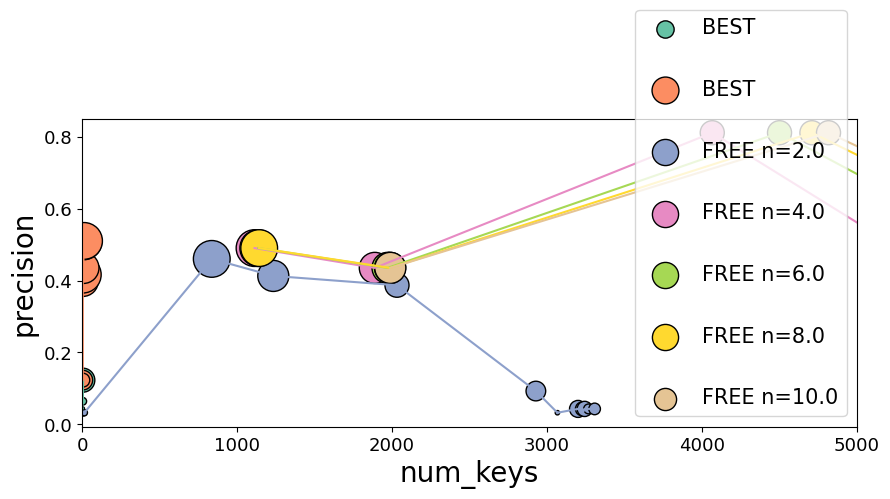

In [34]:
fig, ax = plt.subplots(figsize=(10,4))
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'num_keys']).gram_size.idxmin()].sort_values(by='num_keys')

new_groups = new_res_df.groupby(['name', 'gram_size'])
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1

    X = new_group['num_keys']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color)
    ax.scatter(X, Y, marker='o', label=curr_lab, c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               s=1000*new_group['selectivity'].to_numpy())
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--

ax.set_xlabel('num_keys')
ax.set_ylabel('precision')

ax.set_xlim([0, 5000])
plt.legend(loc="lower right", labelspacing=2)
plt.savefig(f'figs/{FIG_PREFIX}_numkey_prec.pdf', bbox_inches='tight')
plt.show()

In [35]:
new_res_df[new_res_df['num_keys'] < 5000].sort_values(by='num_after_filter', ascending=True)

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,method
377,FREE-parallel,10.0,10.0,0.30,4816.0,35.0039,10.431800,45.4357,1.176186e+09,0.000366,...,46.529505,453940,113485.00,368166,-1,NaN,NaN,0.188954,0.811046,FREE
353,FREE-parallel,10.0,6.0,0.30,4500.0,30.2112,8.922800,39.1340,1.130047e+09,0.000351,...,40.213542,453940,113485.00,368166,-1,NaN,NaN,0.188954,0.811046,FREE
766,FREE-parallel,10.0,4.0,0.30,4066.0,42.5310,7.828570,50.3596,1.070968e+09,0.000366,...,51.653881,453940,113485.00,368166,-1,-1.0,0.0,0.188954,0.811046,FREE
365,FREE-parallel,10.0,8.0,0.30,4709.0,32.2244,9.731910,41.9563,1.157067e+09,0.000364,...,43.049725,453940,113485.00,368166,-1,NaN,NaN,0.188954,0.811046,FREE
764,LPMS-DETERM,16.0,-1.0,-1.00,12.0,234.6500,-1.000000,234.6500,6.084502e+07,0.000154,...,236.002715,643118,160779.50,368166,2875988,15.0,4.0,0.427530,0.572470,LPMS
763,LPMS-DETERM,16.0,-1.0,-1.00,10.0,120.6720,-1.000000,120.6720,6.000005e+07,0.000132,...,122.048073,643133,160783.25,368166,2531032,10.0,4.0,0.427543,0.572457,LPMS
449,BEST-parallel,16.0,-1.0,0.70,13.0,62.8206,0.021698,62.8423,8.479626e+07,0.000145,...,64.293306,721687,180421.75,368166,2204460,15.0,4.0,0.489854,0.510146,BEST
448,BEST-parallel,16.0,-1.0,0.70,10.0,60.5354,0.012429,60.5479,5.616079e+07,0.000139,...,61.993217,723699,180924.75,368166,2245864,10.0,4.0,0.491272,0.508728,BEST
367,FREE-parallel,10.0,8.0,0.70,1143.0,24.5272,7.152780,31.6800,1.148469e+09,0.000169,...,33.029739,751053,187763.25,368166,-1,NaN,NaN,0.509800,0.490200,FREE
355,FREE-parallel,10.0,6.0,0.70,1137.0,23.5884,6.569160,30.1575,1.127238e+09,0.000161,...,31.494829,751053,187763.25,368166,-1,NaN,NaN,0.509800,0.490200,FREE


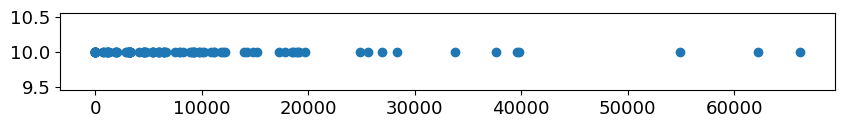

In [36]:
data = np.sort(new_res_df['num_keys'].to_numpy())
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))

In [37]:
# decide the split points
def pairwise_difference(lst):
    differences = []
    prec_diffs = []
    for i in range(len(lst) - 1):
        prec_diffs.append((lst[i + 1] - lst[i])/lst[i])
        differences.append(lst[i + 1] - lst[i])
    return differences, prec_diffs
diffs, prec_diffs = pairwise_difference(data)
idxs = np.argsort(diffs)
prec_idxs = np.argsort(prec_diffs)
print(idxs)

[ 13  17  16   9   8   7  10   5   4   3   6  19  47  12  14  15   1  22
  53  79  54   0  67  33  59  60  68  63  64   2  11  18  20  44  41  45
  46  26  42  40  76  32  86  27  43  25  48  81  39  49  36  34  52  78
  72  62  58  28  66  23  31 100  29  38  97  56  83  77  89  37  69  99
  55  88 109  75  91  73  24  85  82  98  65  71  93  51  80  57  95  61
  30 101  92  87  84  96  74  21  50 103  35  70 104 105  90 108  94 107
 112 102 106 111 110]


/home/ling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


idx[24], between 837.0 and 1113.0
idx[110], between 39801.0 and 54902.0
idx[11], between 5.0 and 7.0
idx[35], between 2032.0 and 2887.0
idx[30], between 1324.0 and 1889.0
idx[1], between 2.0 and 3.0
idx[2], between 3.0 and 5.0
idx[21], between 15.0 and 758.0
idx[0], between 0.0 and 2.0


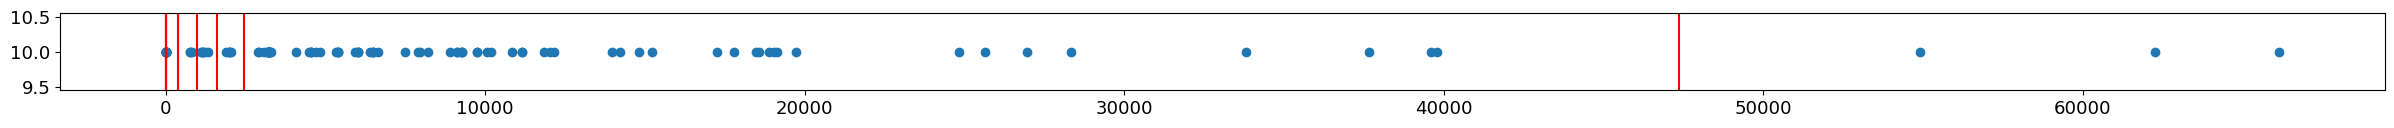

In [38]:
fig, ax = plt.subplots(figsize=(30, 1))
ax.scatter(data, [10] * len(data))
bins = [np.min(data)-1]
for idx in prec_idxs[-9:]:
    print(f'idx[{idx}], between {data[idx]} and {data[idx+1]}')
    curr_x = (data[idx] + data[idx + 1])/2
    bins.append(curr_x)
    ax.axvline(x=curr_x, color='red')
bins = np.sort(bins)
bins = np.append(bins, int(np.max(data)*1.01))

idx[24], between 837.0 and 1113.0 at 975.0
idx[11], between 5.0 and 7.0 at 6.0
idx[35], between 2032.0 and 2887.0 at 2459.5
idx[30], between 1324.0 and 1889.0 at 1606.5
idx[1], between 2.0 and 3.0 at 2.5
idx[2], between 3.0 and 5.0 at 4.0
idx[21], between 15.0 and 758.0 at 386.5
idx[0], between 0.0 and 2.0 at 1.0


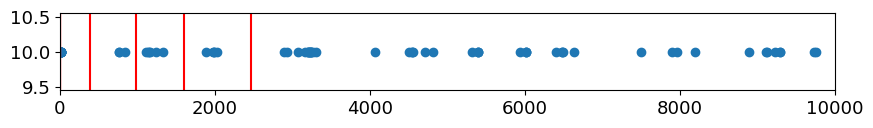

In [39]:
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))
ax.set_xlim([0, 10000])

for idx in prec_idxs[-9:]:
    if data[idx] < 10000:
        print(f'idx[{idx}], between {data[idx]} and {data[idx+1]} at {(data[idx] + data[idx + 1])/2}')
        curr_x = (data[idx] + data[idx + 1])/2
        ax.axvline(x=curr_x, color='red')

In [40]:
print(bins)

[-1.00000e+00  1.00000e+00  2.50000e+00  4.00000e+00  6.00000e+00
  3.86500e+02  9.75000e+02  1.60650e+03  2.45950e+03  4.73515e+04
  6.68080e+04]


In [41]:
name_map = {
    'BEST' : '\\best ',
    'FREE' : '\\free ',
    'FAST' : '\\lpms ',
    'LPMS' : '\\lpms '
}

def check_min_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].min():
        curr_str += '& \cellcolor{green!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str

def check_max_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].max():
        curr_str += '& \cellcolor{yellow!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str
summary_df = None
for up_lim in bins[2:]:
    up_lim = np.ceil(up_lim)
    # print(up_lim)
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    # print(curr_group)
    curr_group = curr_group.sort_values(by='num_keys')
    count = 0
    curr_row_count = curr_group.shape[0]
    curr_group['max_key'] = [up_lim]*curr_row_count
    if summary_df is None:
        summary_df = curr_group
    else:
        summary_df = pd.concat([summary_df, curr_group], ignore_index=True)

    for _, row in curr_group.iterrows():
        curr_str = ''
        count += 1;
        if count == 1:
            curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+str(int(up_lim))+'}}'
        curr_str += f'& {name_map[row["name"][:4]]} '

        curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.1f}', curr_group)
        curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.3f}', curr_group)
        curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.1f}', curr_group)
        curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3f}', curr_group)
        print(curr_str, end='')
        if count < curr_row_count:
            print("\\\\ \cline{2-7}")
        else:
            print("\\\\ \hline")
    # print(curr_group)

\multirow{2}{*}{\bf{3}}& \lpms  & 4.8 & 520 & 4.643 & 0.0 & 0.032 \\ \cline{2-7}
& \best  & \cellcolor{green!50}{3.0} & \cellcolor{green!50}{59} & \cellcolor{green!50}{-0.000} & \cellcolor{green!50}{0.0} & \cellcolor{yellow!50}{0.064} \\ \hline
\multirow{2}{*}{\bf{4}}& \lpms  & 4.8 & 520 & 4.643 & 0.0 & 0.032 \\ \cline{2-7}
& \best  & \cellcolor{green!50}{3.0} & \cellcolor{green!50}{59} & \cellcolor{green!50}{-0.000} & \cellcolor{green!50}{0.0} & \cellcolor{yellow!50}{0.064} \\ \hline
\multirow{3}{*}{\bf{6}}& \best  & \cellcolor{green!50}{1.5} & 57 & 2.188 & 31.7 & \cellcolor{yellow!50}{0.416} \\ \cline{2-7}
& \free  & 4.9 & \cellcolor{green!50}{29} & \cellcolor{green!50}{0.969} & \cellcolor{green!50}{0.0} & 0.032 \\ \cline{2-7}
& \lpms  & 1.8 & 35 & 2.139 & 53.1 & 0.209 \\ \hline
\multirow{3}{*}{\bf{387}}& \lpms  & \cellcolor{green!50}{1.4} & 235 & 2.876 & 60.8 & \cellcolor{yellow!50}{0.572} \\ \cline{2-7}
& \best  & 1.5 & 63 & 2.204 & 84.8 & 0.510 \\ \cline{2-7}
& \free  & 4.9 & \cel

In [42]:
summary_df

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,max_key
0,LPMS-RANDOM,16.0,-1.0,-1.00,0.0,519.9270,-1.000000,519.9270,8.280000e+03,0.000135,...,524.780396,11381372,2845343.00,368166,4643008,5.0,4.0,0.967652,0.032348,3.0
1,BEST,10.0,-1.0,0.02,3.0,59.2121,0.000291,59.2124,4.000000e+02,0.000096,...,62.222752,5726490,1431622.50,368166,-1,NaN,NaN,0.935708,0.064292,3.0
2,LPMS-RANDOM,16.0,-1.0,-1.00,0.0,519.9270,-1.000000,519.9270,8.280000e+03,0.000135,...,524.780396,11381372,2845343.00,368166,4643008,5.0,4.0,0.967652,0.032348,4.0
3,BEST,10.0,-1.0,0.02,3.0,59.2121,0.000291,59.2124,4.000000e+02,0.000096,...,62.222752,5726490,1431622.50,368166,-1,NaN,NaN,0.935708,0.064292,4.0
4,BEST-parallel,16.0,-1.0,0.70,5.0,57.0475,0.007642,57.0552,3.171839e+07,0.000136,...,58.563376,884280,221070.00,368166,2187780,5.0,4.0,0.583654,0.416346,6.0
5,FREE-parallel,16.0,2.0,0.02,5.0,28.3297,0.942652,29.2724,1.537800e+04,0.000173,...,34.212158,11381372,2845343.00,368166,969100,5.0,0.0,0.967652,0.032348,6.0
6,LPMS-DETERM,16.0,-1.0,-1.00,5.0,34.9143,-1.000000,34.9143,5.307963e+07,0.001151,...,36.737224,1758091,439522.75,368166,2139184,5.0,4.0,0.790588,0.209412,6.0
7,LPMS-DETERM,16.0,-1.0,-1.00,12.0,234.6500,-1.000000,234.6500,6.084502e+07,0.000154,...,236.002715,643118,160779.50,368166,2875988,15.0,4.0,0.427530,0.572470,387.0
8,BEST-parallel,16.0,-1.0,0.70,13.0,62.8206,0.021698,62.8423,8.479626e+07,0.000145,...,64.293306,721687,180421.75,368166,2204460,15.0,4.0,0.489854,0.510146,387.0
9,FREE-parallel,16.0,2.0,0.02,15.0,26.5028,1.319560,27.8224,2.310200e+04,0.000147,...,32.758554,11381372,2845343.00,368166,968868,15.0,0.0,0.967652,0.032348,387.0


In [43]:
for up_lim in bins[1:]:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    print(up_lim)
    # print(curr_df.groupby(['method']).precision.idxmax())
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    print(curr_group)

1.0
               name  num_threads  gram_size  selectivity  num_keys  \
method                                                               
LPMS    LPMS-RANDOM         16.0       -1.0         -1.0       0.0   

        selection_time  build_time  overall_index_time  index_size  \
method                                                               
LPMS           519.927        -1.0             519.927      8280.0   

        compile_time  ...  overall_match_time  overall_time  num_after_filter  \
method                ...                                                       
LPMS        0.000135  ...            4.833507    524.780396          11381372   

        per_query_num_after_filter  match_count  compute_size  \
method                                                          
LPMS                     2845343.0       368166       4643008   

        key_upper_bound  num_queries  prop_error  precision  
method                                                       
LPMS      

[        nan  0.          0.91629073  1.38629436  1.79175947  5.95713187
  6.88243747  7.38181318  7.80771336 10.76535378 11.10957811]


/home/ling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


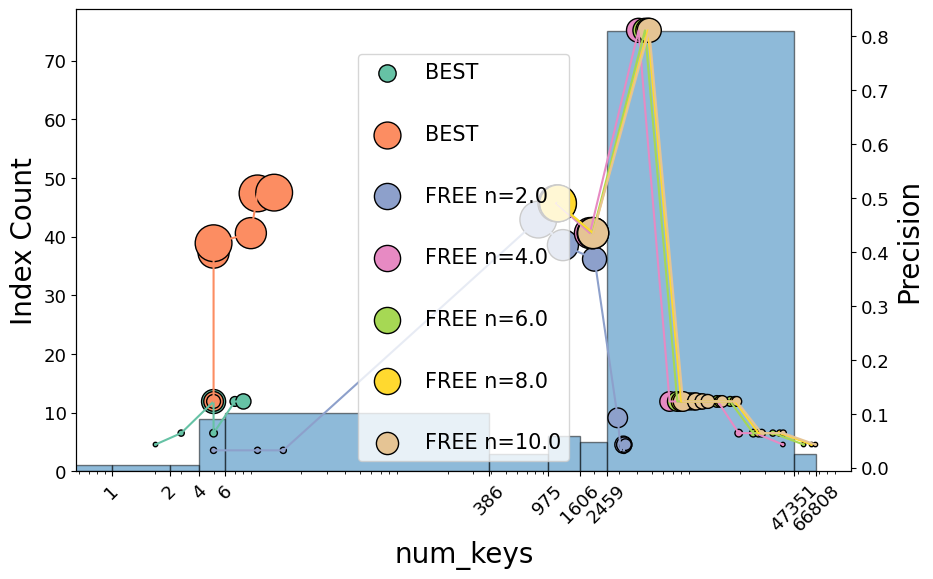

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data, bins=bins, edgecolor='black', alpha=0.5)
print(np.log(bins))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.gca().set_xscale("log")
ax.set_xticks(bins)
ax.set_xticklabels([int(b) for b in bins], rotation=45)

ax2 = ax.twinx()

for (name, new_group), color in zip(new_groups, colors):
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1

    X = new_group['num_keys']
    Y = new_group['precision']
    ax2.plot(X, Y, c=color)
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    sc = ax2.scatter(X, Y, marker='o', label=curr_lab, c=color,
               edgecolors='black', #alpha=new_group['selectivity'].to_list(), 
               s=1000*new_group['selectivity'].to_numpy())
    if name[0] == 'FREE-parallel':
        labs = (new_group['selectivity'].unique())
        labs = np.sort(labs)
        handles, labels = sc.legend_elements(prop="sizes", alpha=0.4,num=4)     
        # labels = new_group['selectivity'].unique()    
        # legend = ax.legend(handles, [" " , "Selectivity\nThreshold"," " ,  " "], title="Size")
        # ax.legend(*sc.legend_elements("sizes", num=4, alpha=0.5), loc='center right')

    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax2.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
ax2.set_ylabel('Precision')
ax.set_ylabel('Index Count')
ax.set_xlabel('num_keys')
plt.legend(labelspacing=2)
plt.savefig(f'figs/{FIG_PREFIX}_numkey_prec_hist.pdf', bbox_inches='tight')
plt.show()

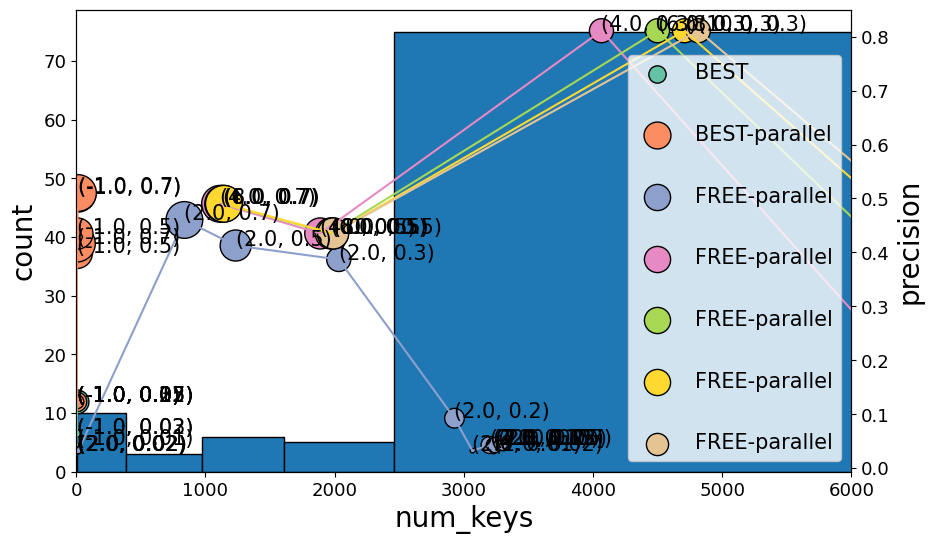

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data, bins=bins, edgecolor='black');
# plt.gca().set_xscale("log")
ax2 = ax.twinx()

for (name, new_group), color in zip(new_groups, colors):
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1
    if name == 'FREE-parallel':
        curr_new_group = new_group[new_group['gram_size'] == 4]
    else:
        curr_new_group = new_group
    X = curr_new_group['num_keys']
    Y = curr_new_group['precision']
    ax2.plot(X, Y, c=color)
    ax2.scatter(X, Y, marker='o', label=curr_new_group['name'].to_list()[0], c=color,
               edgecolors='black', #alpha=new_group['selectivity'].to_list(), 
               s=1000*curr_new_group['selectivity'].to_numpy())
    for g, s, x, y in zip(curr_new_group['gram_size'], curr_new_group['selectivity'], X, Y):
        ax2.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
ax2.set_ylabel('precision')
ax.set_ylabel('count')
ax.set_xlabel('num_keys')
ax.set_xlim([0, 6000])
plt.legend(labelspacing=2)

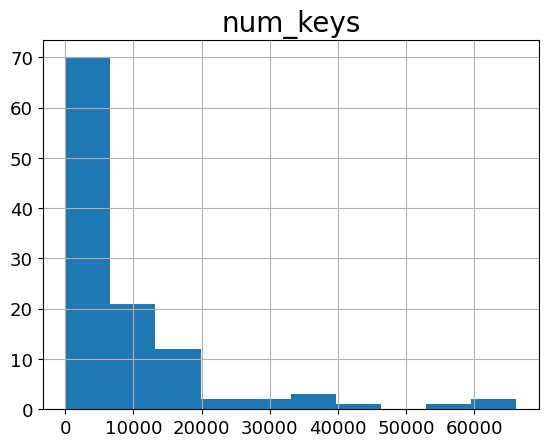

In [46]:
# bin them by number of 
BIN_NUM = 10
new_res_df.hist(column='num_keys', bins=BIN_NUM)
heights, bins = np.histogram(data, bins=BIN_NUM)

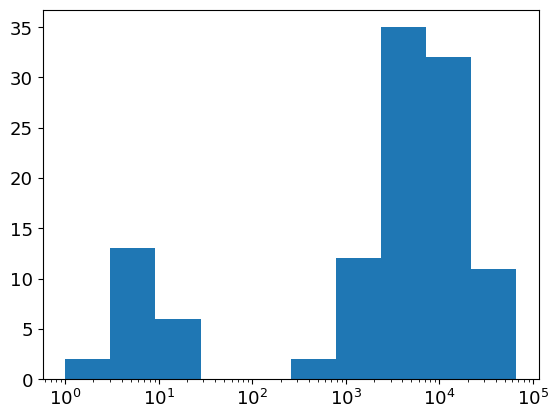

In [47]:
_, bins = np.histogram(np.log10(data + 1), bins=BIN_NUM)
plt.hist(data, bins=10**bins);
plt.gca().set_xscale("log")

In [48]:
edges = 10**bins
prev = 0
for b in edges:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True)[['name', 'num_keys', 'selection_time', 'num_after_filter']])
    prev = b
print([int(e) for e in edges])

            name  num_keys  selection_time  num_after_filter
765  LPMS-RANDOM       0.0         519.927          11381372
    name  num_keys  selection_time  num_after_filter
51  BEST       3.0         59.2121           5726490
50  BEST       2.0         40.7472           8540928
              name  num_keys  selection_time  num_after_filter
446  BEST-parallel       9.0         53.8472            846295
447  BEST-parallel       5.0         57.0475            884280
445  BEST-parallel       5.0         51.0892            923001
762    LPMS-DETERM       5.0         34.9143           1758091
53            BEST       7.0        261.8820           2993200
54            BEST       8.0        350.8460           2993200
56            BEST       8.0        960.3920           2993334
441  BEST-parallel       5.0         46.8076           2993706
443  BEST-parallel       5.0         46.9960           2993840
439  BEST-parallel       5.0         46.7587           2994721
59            BEST       5

/home/ling/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: autodetected range of [-inf, 4.820510152182017] is not finite

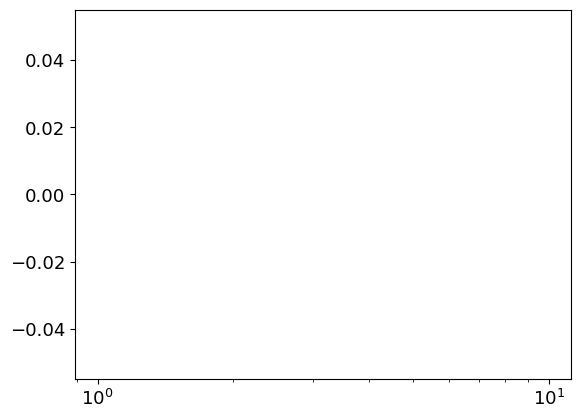

In [49]:
sns.histplot(new_res_df['num_keys'], bins=BIN_NUM, log_scale=True)

In [ ]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

In [ ]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
x = new_res_df['num_keys'].to_numpy()
n, bins, patches = plt.hist(x, histedges_equalN(x, 20))

In [ ]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

In [ ]:
best_df = res_df[res_df['name'].str.contains('BEST')]

In [ ]:
free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]

In [ ]:
# free with c = 0.1, plot false positive rate against gramsize 
# free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]
temp_free = free_df[free_df['selectivity'] == 0.1]

In [ ]:
# gram size vs accuracy
temp = temp_free[temp_free['num_threads'] == 1]
ax = plt.subplot()
x = temp['gram_size']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
ax.plot(x, y) 
plt.xlabel('Max Gram Size')
plt.ylabel('False Positive Rate')
plt.show()

In [ ]:
# gram size vs index size; gram size vs index build time
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

colors = ['#66c2a5','#fc8d62','#8da0cb']

temp = temp_free[temp_free['num_threads'] == 1]
x = temp['gram_size']
y_1 = temp['overall_index_time']
y_1_1 = temp['selection_time']
y_1_2 = temp['build_time']

y_2 = temp['num_keys']

axs[0].stackplot(x, y_1_1, y_1_2, labels=[
    'Gram Selection', 'Posting Lists Filling' #, 'Overall Index Construction'
],
    colors=colors[:-1])

# axs[0].plot(x, y_1, label='Overall Index Construction') 
# axs[0].plot(x, y_1_1, label='Gram Selection') 
# axs[0].plot(x, y_1_2, label='Posting Lists Filling') 
axs[0].set_ylabel('Time (s)')
axs[0].legend(loc='upper left')

axs[1].plot(x, y_2, marker='o', c=colors[-1])
axs[1].set_ylabel('Num Selected')

plt.xlabel('Max Gram Size')
plt.savefig(f'figs/{FIG_PREFIX}free_n_vs_index-time_num-keys.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# thread vs. build time; label by gram size
ax = plt.subplot()
seq_colors = sns.color_palette("flare")#, as_cmap=True)
for i, gram_size in enumerate(temp_free['gram_size'].unique()):
    temp = temp_free[temp_free['gram_size'] == gram_size]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='FREE max {}-grams'.format(int(gram_size)), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}free_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# thread vs. build time; label by gram size
# temp_best = best_df[best_df['selectivity'] == 0.05]
# print(temp_best)
ax = plt.subplot()
seq_colors = sns.color_palette("crest")#, n_colors=11)#, as_cmap=True)
# for i, sel in enumerate(best_df['selectivity'].unique()):
for i, sel in enumerate([0.01, 0.05,0.1, 0.2]):
    temp = best_df[best_df['selectivity'] == sel]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='BEST c <= {}'.format(sel), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}_best_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()